# Markowitz Portfolio Theory
**Step 1: Carving Out the Efficient Frontier**
- Security analyst provides expected return, risk, and covariance data as an input list.
- The objective in this step is to construct a set of portfolios that form the efficient frontier, representing the optimal risk-return trade-off.

**Step 1 Substeps:**
1. Calculate the expected returns, risk (typically measured by standard deviation), and covariances between the assets in the input list.
2. For each target return, find the portfolio with the minimum risk (standard deviation) that achieves that return. These portfolios together form the efficient frontier, representing various risk-return possibilities.

**Step 2: Obtaining the Tangency Portfolio**
- In this step, the risk-free asset is introduced, and the goal is to find the portfolio that offers the best risk-return trade-off, considering both risky assets and the risk-free asset. This portfolio is known as the tangency portfolio.

**Step 2 Substeps:**
1. Introduce a risk-free asset, typically represented by a government bond with a known return and zero risk.
2. Calculate the Sharpe ratio for all portfolios on the efficient frontier. The Sharpe ratio measures the excess return of a portfolio per unit of risk.
3. Identify the portfolio on the efficient frontier with the highest Sharpe ratio. This portfolio is the tangency portfolio and is independent of the risk aversion of investors.

**Separation Property:**
- The separation property is a key concept in portfolio management, suggesting that the overall task of portfolio management can be divided into two independent tasks. These tasks are:

1. **Determination of the Optimal Risky Portfolio:** This involves choosing the portfolio of risky assets that best balances risk and return (the tangency portfolio), which is the same for all investors and independent of their risk aversion.

2. **Tailoring the Portfolio to Suit an Investor's Risk Aversion:** After the optimal risky portfolio is determined, investors can then customize their portfolios based on their individual risk preferences by allocating between the risk-free asset and the optimal risky portfolio. The proportion allocated to the risk-free asset will depend on the investor's risk aversion.

The separation property allows investors to make investment decisions based on their unique risk tolerance without affecting the selection of the optimal risky portfolio.


In [29]:
import numpy as np
import pandas as pd
import scipy.optimize as sc 
import matplotlib.pyplot as plt 
from ipywidgets import interact
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
yf.pdr_override()
import requests
from scipy.stats import norm

In [30]:
stocks=['AAPL','NFLX','FL','LMT']
end=dt.datetime.now()
start=end-dt.timedelta(days=365*5) # Past 5 years data
type(end)

datetime.datetime

In [31]:
def getStockData(stocks,start,end):
    """Fetches stock data from yahoo finance

    Args:
        stocks (list): List of stocks
        start (datetime): Start date
        end (datetime): End date

    Returns:
        pandas.Dataframe: A dataframe with the details of the stock
    """
    stock_data=pdr.get_data_yahoo(stocks,start,end)
    return stock_data


In [32]:
stock_data=getStockData(stocks,start,end)

[**********************50%%                      ]  2 of 4 completed

c:\Users\Rama Balasubramanian\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Rama Balasubramanian\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Rama Balasubramanian\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Rama Balasubramanian\AppData\Local\Programs\Py

[*********************100%%**********************]  4 of 4 completed


In [33]:
def getDailyReturns(stock_data):
    """Calculates the daily returns

    Args:
        stock_data (pd.Dataframe): A dataframe containing the details of stocks 

    Returns:
        pd.Dataframe: A dataframe containing the daily returns of each stock
    """
    dailyReturns=stock_data['Adj Close'].pct_change()
    dailyReturns=dailyReturns.dropna()
    return dailyReturns

In [34]:
dailyReturns=getDailyReturns(stock_data)

In [35]:
meanReturns=(1+dailyReturns.mean())**252-1 # Annualizing the daily returns
covMatrix=dailyReturns.cov()*252 # Annualizing the covariance matrix
n=len(meanReturns) # Number of assets

Portfolio Variance :- 

$\sigma_P^2=w^{\prime} \sum w$

Portfolio Expected return :- 

$\quad E\left(r_P\right)=w^{\prime} \mu$

$w^{\prime} \mathbf{1}=1$ (Sum of the weights should be 1)

$\mu$ - vector of expected returns of the assets


In [36]:
def portfolioPerformance(weights,meanReturns,covMatrix):
    """Computes the risk and return of the portfolio

    Args:
        weights : Weights of the stocks
        meanReturns : The annualized mean return of each stock
        covMatrix : The annualized covariance matrix of the stocks

    Returns:
        A tuple consisting of annualized portfolio return and risk
    """
    expectedReturn=np.sum(weights*meanReturns)
    risk=np.sqrt(np.dot(weights.T,np.dot(covMatrix, weights)))
    return expectedReturn,risk

In [37]:
"""The functions in this section are used to retrieve 
portfolio return and risk from the tuple returned by portfolioPerformance()"""
def annualizedPortfolioReturn(weights,meanReturns,covMatrix):
    return portfolioPerformance(weights,meanReturns,covMatrix)[0]
def annualizedPortfolioRisk(weights,meanReturns,covMatrix):
    return portfolioPerformance(weights,meanReturns,covMatrix)[1]

## Maximum Sharpe ratio

In [38]:

constraintSet=(0,1)
risk_free_rate=0.05
def negativeSharpeRatio(weights,meanReturns,covMatrix,risk_free_rate):
    """Computes the negative Sharpe ratio, which will eventually be minimized

    Args:
        weights : Weights of the stocks
        meanReturns : The annualized mean return of each stock
        covMatrix : The annualized covariance matrix of the stocks
        risk_free_rate : The Risk free rate

    Returns:
         The Negative Sharpe Ratio
    """
    expectedReturn=annualizedPortfolioReturn(weights,meanReturns,covMatrix)
    risk=annualizedPortfolioRisk(weights,meanReturns,covMatrix)
    return -(expectedReturn-risk_free_rate)/risk

def maxSharpeRatio(meanReturns,covMatrix,risk_free_rate):
    """Maximizes the Sharpe Ratio given mean returns, covariance matrix and risk free rate.

       This function uses the minimize function from the scipy.optimize library to minimize
       the negative Sharpe ratio, since minimizing the negative Sharpe ratio will automatically
       maximize the Sharpe ratio

    Args:
        weights : Weights of the stocks
        meanReturns : The annualized mean return of each stock
        covMatrix : The annualized covariance matrix of the stocks
        risk_free_rate : The Risk free rate

    Returns:
        A scipy optimize result object containing the result of the optimization like weights, Max sharpe ratio etc.
    """
    args=(meanReturns,covMatrix,risk_free_rate)
    constraints={'type':'eq','fun':lambda x:np.sum(x)-1}
    bound = constraintSet
    bounds = tuple(bound for asset in range(n))
    result=sc.minimize(negativeSharpeRatio,x0=n*[1./n],args=args,method='SLSQP',bounds=bounds,constraints=constraints)
    return result

# Minimum Variance Portfolio

$\operatorname{Min} \sigma_P^2=w^{\prime} \sum w$
constraint: $w^{\prime} \mathbf{1}=1$

where
- $w$-vector of asset weights
- $\quad \Sigma$-variance-covariance matrix

In [39]:
def minimizePortfolioVariance(meanReturns,covMatrix):
    """Minimizes the portfolio variance given mean returns and covariance matrix of the stock

    Args:
        meanReturns : The annualized mean return of each stock
        covMatrix : The annualized covariance matrix of the stocks

    Returns:
        A scipy optimize result object containing the result of the optimization like weights, Minimum Variance etc.
    """
    args=(meanReturns,covMatrix)
    constraints={'type':'eq','fun':lambda x:np.sum(x)-1}
    bound = constraintSet
    bounds = tuple(bound for asset in range(n))
    result=sc.minimize(annualizedPortfolioRisk,n*[1./n],args=args,method='SLSQP',bounds=bounds,constraints=constraints)
    return result

# Efficient portfolio (E):

$
\operatorname{Min} \sigma_P^2=w^{\prime} \sum w
$

Constraints: 

- $\quad E\left(r_P\right)=w^{\prime} \mu$ 
- $w^{\prime} \mathbf{1}=1$

$\mu$ - vector of expected returns of the assets

In [40]:
def efficientPortfolios(meanReturns,covMatrix,targetReturns):
    """Generates various efficient portfolio. 

    Args:
        meanReturns : The annualized mean return of each stock
        covMatrix : The annualized covariance matrix of the stocks
        targetReturns : The various returns that are desired by the investor

    Returns:
        _type_: _description_
    """
    args=(meanReturns,covMatrix)
    constraints=({'type':'eq','fun':lambda x:np.sum(x)-1},
                 {'type':'eq','fun':lambda x:annualizedPortfolioReturn(x,meanReturns,covMatrix)-targetReturns})
    bound = constraintSet
    bounds = tuple(bound for asset in range(n))
    result=sc.minimize(annualizedPortfolioRisk,n*[1./n],args=args,method='SLSQP',bounds=bounds,constraints=constraints)
    return result

In [41]:
def results(meanReturns,covMatrix):
    """Summarizes the results of the portfolio optimizations.
       1. Max. Sharpe Ratio portfolio(Optimal portfolio) :- Weights,Return and Risk
       2. Min Variance portfolio :- Weights,Return and Risk
       3. Minimum Risks for each of the random target returns

    Args:
        meanReturns : The annualized mean return of each stock
        covMatrix : The annualized covariance matrix of the stocks

    Returns:
        A tuple containing the following elements:-
         -Asset allocation in the Max. Sharpe Ratio portfolio
         -Return of the Max. Sharpe Ratio portfolio
         -Risk of the Max. Sharpe Ratio portfolio
         -Asset allocation in the Min. Variance portfolio
         -Return of the Min. Variance portfolio
         -Risk of the Min. Variance portfolio
    """
    maxSR_portfolio=maxSharpeRatio(meanReturns,covMatrix,risk_free_rate)
    maxSR_portfolio_expectedReturn=annualizedPortfolioReturn(maxSR_portfolio['x'],meanReturns,covMatrix)
    maxSR_portfolio_risk=annualizedPortfolioRisk(maxSR_portfolio['x'],meanReturns,covMatrix)
    maxSR_allocation=pd.DataFrame(maxSR_portfolio['x'], index=meanReturns.index, columns=['allocation'])
    maxSR_allocation.allocation = [round(i,7) for i in maxSR_allocation.allocation]

    minVar_portfolio=minimizePortfolioVariance(meanReturns,covMatrix)
    minVar_portfolio_expectedReturn=annualizedPortfolioReturn(minVar_portfolio['x'],meanReturns,covMatrix)
    minVar_portfolio_risk=annualizedPortfolioRisk(minVar_portfolio['x'],meanReturns,covMatrix)
    minVar_allocation=pd.DataFrame(minVar_portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVar_allocation.allocation = [round(i,7) for i in minVar_allocation.allocation]

    efficientRisk=[]
    targetReturns=np.linspace(minVar_portfolio_expectedReturn,maxSR_portfolio_expectedReturn,30)
    for target in targetReturns:
        efficientRisk.append(efficientPortfolios(meanReturns,covMatrix,target)['fun'])
    return (maxSR_allocation,maxSR_portfolio_expectedReturn,maxSR_portfolio_risk,
            minVar_allocation,minVar_portfolio_expectedReturn,minVar_portfolio_risk,
            efficientRisk,targetReturns)

In [42]:
(maxSR_allocation,maxSR_portfolio_expectedReturn,maxSR_portfolio_risk,
            minVar_allocation,minVar_portfolio_expectedReturn,minVar_portfolio_risk,
            efficientRisk,targetReturns)=results(meanReturns,covMatrix)

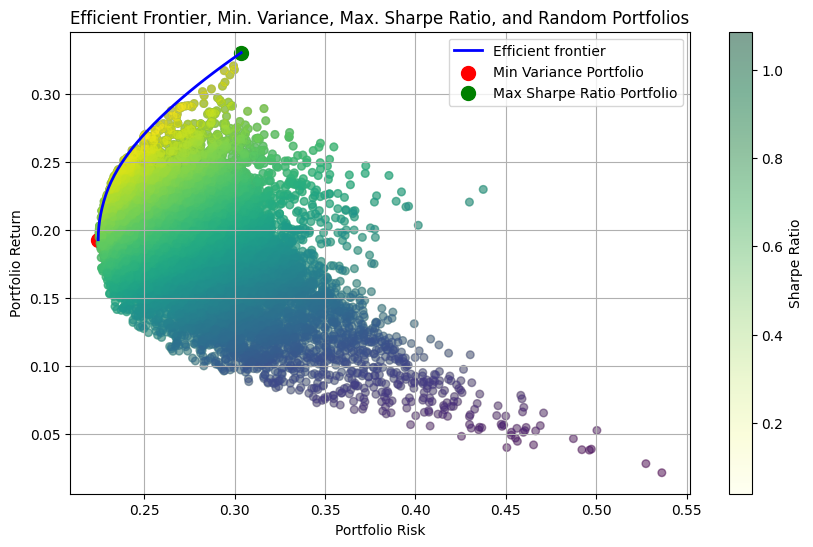

In [43]:
"""
In this section :-
1. Generation of random portfolios
2. Plotting the efficient frontier, Max. Sharpe ratio, Min. Variance portfolio and the random portfolios
"""

# Generating the random portfolios
randomPortfolios=10000
randomPortfolios_weights=np.empty((randomPortfolios,n)) 
randomPortfolios_expectedReturns=np.empty(randomPortfolios)
randomPortfolios_risk=np.empty(randomPortfolios)

#Filling the empty arrays with the returns and risks
for i in range(randomPortfolios):
    weights=np.random.rand(len(meanReturns))
    weights=weights/weights.sum()
    randomPortfolios_weights[i]=(weights)
    randomPortfolios_expectedReturns[i]=np.sum(weights*meanReturns)
    randomPortfolios_risk[i]=np.sqrt(np.dot(weights.T,np.dot(covMatrix, weights)))


plt.figure(figsize=(10,6))
plt.plot(efficientRisk,targetReturns,label='Efficient frontier',color='blue',linewidth=2)
plt.scatter(minVar_portfolio_risk,minVar_portfolio_expectedReturn, color='red', marker='o', s=100, label='Min Variance Portfolio')
plt.scatter(maxSR_portfolio_risk,maxSR_portfolio_expectedReturn, color='green', marker='o', s=100, label='Max Sharpe Ratio Portfolio')
cmap=plt.get_cmap('YlGn')
scatter = plt.scatter(randomPortfolios_risk, randomPortfolios_expectedReturns, marker='o', s=30, alpha=0.5, c=randomPortfolios_expectedReturns/randomPortfolios_risk, cmap=cmap)
cbar=plt.colorbar(scatter,label='Sharpe Ratio',orientation='vertical')
plt.scatter(randomPortfolios_risk, randomPortfolios_expectedReturns, marker='o', s=30, alpha=0.5,c=randomPortfolios_expectedReturns/randomPortfolios_risk)
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier, Min. Variance, Max. Sharpe Ratio, and Random Portfolios')
plt.grid(True)
plt.legend()

plt.show()



# Capital Allocation line

$E(R_C) = y\cdot E(R_P) + (1-y)\cdot R_f$

$\sigma_C = {y \cdot \sigma_P}$


where 
- y is the allocation to the risky portfolio
- C is the complete portfolio 
- P is the risky portfolio



# Utility equation

$U = E(r_C) - 0.5 \cdot A \cdot \sigma_C^2$

where
- A is the degree of risk aversion of an investor

Assumption :- All investors are rational (no gambling)

We have found out the optimal(tangency) portfolio but depending on different degrees of risk aversion the allocation (y) can change.
We know that the objective of an investor is to maximze utility. 

$y^* = \frac{{E(r_P) - r_f}}{{A \sigma_P^2}} = \frac{{S}}{{A \sigma_P}}$

$y^*$ is the allocation maximizes utility for a given risk and return





In [48]:
"""Calculates the allocation between risk-free and risky assets for a given degree of risk aversion """
def completePortfolio(A):
    """Calculates the allocation between risk-free and risky assets for a given degree of risk aversion 

    Args:
        A : Degree of risk aversion
    """
    sharpe_ratio=(-1)*maxSharpeRatio(meanReturns,covMatrix,risk_free_rate)['fun']
    sigma_p=maxSR_portfolio_risk
    y_optimal=(sharpe_ratio)/(A*sigma_p)
    complete_portfolio_return=y_optimal*(maxSR_portfolio_expectedReturn)+(1-y_optimal)*(risk_free_rate)
    complete_portfolio_risk=y_optimal*maxSR_portfolio_risk
    x1,y1=0,risk_free_rate
    x2,y2=maxSR_portfolio_risk,maxSR_portfolio_expectedReturn

    plt.figure(figsize=(10,6))
    plt.plot(efficientRisk,targetReturns,label='Efficient Frontier',color='blue',linewidth=2)
    plt.scatter(minVar_portfolio_risk,minVar_portfolio_expectedReturn,color='red',marker='o',s=100,label='Min. Variance Portfolio')
    plt.scatter(maxSR_portfolio_risk,maxSR_portfolio_expectedReturn,color='green',marker='o',s=100,label='Min. Variance Portfolio')
    plt.plot([x1,x2],[y1,y2],color='orange',linestyle='--',label='CAL',linewidth=1)
    cmap=plt.get_cmap('YlGn')
    scatter=plt.scatter(randomPortfolios_risk,randomPortfolios_expectedReturns,marker='o',s=30,alpha=0.5,cmap=cmap)
    cbar = plt.colorbar(scatter, label='Sharpe Ratio', orientation='vertical')
    plt.scatter(randomPortfolios_risk,randomPortfolios_expectedReturns,marker='o',s=30,alpha=0.5,c=randomPortfolios_expectedReturns/randomPortfolios_risk)
    plt.scatter(complete_portfolio_risk,complete_portfolio_return,color='purple',marker='o',s=100,label='Complete Portfolio')
    plt.xlabel('Risk')
    plt.ylabel('Portfolio Return')
    plt.title('CAL')
    plt.grid()
    plt.show()

In [49]:
"""Allows the user to visualize the CAL, and the portfolio for different levels of risk aversion"""
interact(completePortfolio,A=(1,50,1.0))

interactive(children=(FloatSlider(value=25.0, description='A', max=50.0, min=1.0, step=1.0), Output()), _dom_c…

<function __main__.completePortfolio(A)>

# Simulating the value of the portfolio
Simulating the value of the portfolio over a time horizon using Monte Carlo method

![cholesky.png](cholesky.png)

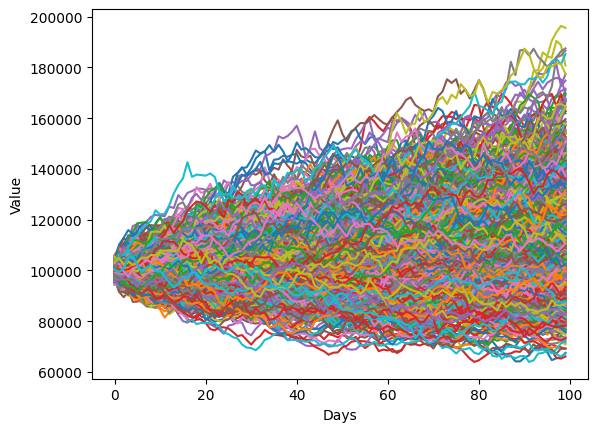

In [62]:
mean_returns=dailyReturns.mean()
cov_matrix=dailyReturns.cov()
weights=maxSR_allocation
simulations=1000
time=100 # No. of days
investment=100000
mean_matrix=np.full(shape=(time,n),fill_value=mean_returns)
portfolio_simulations=np.full(shape=(time,simulations),fill_value=0.0)
for sim in range(simulations):
    z=np.random.normal(size=(time,n))
    l=np.linalg.cholesky(cov_matrix)
    r=mean_matrix+np.inner(z,l)
    portfolio_simulations[:,sim]=np.cumprod(np.inner(r,weights.T)+1)*investment

plt.xlabel('Days')
plt.ylabel('Value')
plt.plot(portfolio_simulations)
plt.show()